In [1]:
import re
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import matplotlib.pyplot as plt
from collections import Counter
from Bio.Blast import NCBIWWW, NCBIXML
import numpy as np
import pandas as pd

file_path = "reads_for_analysis.fastq"

In [2]:
# (a) Nustatyti kokybės kodavimą
def detect_quality_encoding(fastq_file):
    quality_scores = []
    
    for record in SeqIO.parse(fastq_file, "fastq"):
        quality_scores.extend(record.letter_annotations["phred_quality"])
    
    min_score = min(quality_scores)
    max_score = max(quality_scores)
    
    if 0 <= min_score <= 93 and 33 <= max_score <= 126:
        return "Sanger (Phred+33)"
    elif -5 <= min_score and max_score <= 40 and 64 <= max_score:
        return "Solexa (Solexa+64)"
    elif 0 <= min_score <= 40 and 64 <= max_score <= 104:
        return "Illumina 1.3+ (Phred+64)"
    elif 3 <= min_score <= 40 and 64 <= max_score <= 104:
        return "Illumina 1.5+ (Phred+64)"
    elif 0 <= min_score <= 41 and 33 <= max_score <= 74:
        return "Illumina 1.8+ (Phred+33)"
    else:
        return "Nežinomas"

In [3]:
# (b) Analizuoti C/G pasiskirstymą
def analyze_gc_content(fastq_file):
    gc_ratios = []
    sequences = []

    for record in SeqIO.parse(fastq_file, "fastq"):
        sequence = record.seq
        gc_count = sequence.count("G") + sequence.count("C")
        gc_ratio = (gc_count / len(sequence)) * 100
        gc_ratios.append(gc_ratio)
        sequences.append((gc_ratio, record.id, str(sequence)))

    bins = range(0, 101, 5)
    plt.hist(gc_ratios, bins=bins, edgecolor='black', alpha=0.7)
    plt.title("C/G nukleotidų pasiskirstymas")
    plt.xlabel("C/G dalis (%)")
    plt.ylabel("Read'ų skaičius")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    hist, bin_edges = np.histogram(gc_ratios, bins=bins)
    peak_bins = []
    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            peak_bins.append(bin_edges[i])

    peak_sequences = {}
    for peak in peak_bins:
        bin_min = peak
        bin_max = peak + 5
        filtered_seqs = [
            (gc, seq_id, seq)
            for gc, seq_id, seq in sequences
            if bin_min <= gc < bin_max
        ]
        peak_sequences[peak] = filtered_seqs[:5] 

    all_ranges_sequences = {}
    for i in range(len(bin_edges) - 1):
        bin_min = bin_edges[i]
        bin_max = bin_edges[i + 1]
        filtered_seqs = [
            (gc, seq_id, seq)
            for gc, seq_id, seq in sequences
            if bin_min <= gc < bin_max
        ]
        all_ranges_sequences[f"{bin_min}-{bin_max}"] = filtered_seqs[:5]

    return peak_sequences, all_ranges_sequences


In [4]:
# (c) BLAST'o analizė
def perform_blast_search(sequences, database="nt", organism="bacteria"):
    results = []
    for record_id, sequence in sequences:
        print(f"BLAST search for {record_id}")
        result_handle = NCBIWWW.qblast(program="blastn", database=database, sequence=sequence, entrez_query=organism)
        blast_record = NCBIXML.read(result_handle)
        if blast_record.alignments:
            top_hit = blast_record.alignments[0].hit_def
            results.append((record_id, top_hit.split(" ")[0]))
        else:
            results.append((record_id, "No match"))
    return results

Kokybės kodavimas: Sanger (Phred+33)


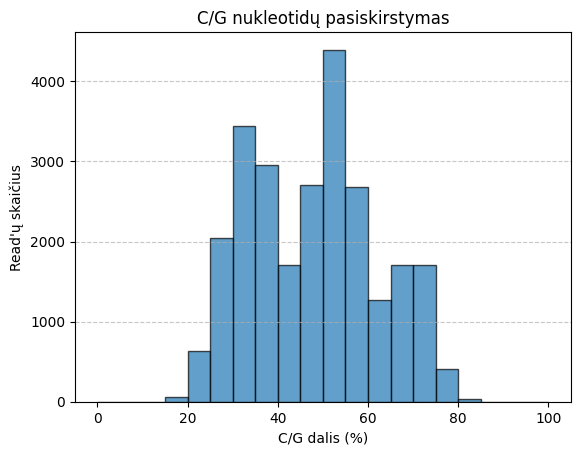

Gauti stambūs piko taškai: 3
BLAST search for M00827:12:000000000-AEUNW:1:1101:12983:1610
BLAST search for M00827:12:000000000-AEUNW:1:1101:13901:2032
BLAST search for M00827:12:000000000-AEUNW:1:1101:21543:2685
BLAST search for M00827:12:000000000-AEUNW:1:1101:20667:3491
BLAST search for M00827:12:000000000-AEUNW:1:1101:22513:3532
BLAST search for M00827:12:000000000-AEUNW:1:1101:18967:1954
BLAST search for M00827:12:000000000-AEUNW:1:1101:13519:2271
BLAST search for M00827:12:000000000-AEUNW:1:1101:18503:2566
BLAST search for M00827:12:000000000-AEUNW:1:1101:14568:2958
BLAST search for M00827:12:000000000-AEUNW:1:1101:15296:3158
BLAST search for M00827:12:000000000-AEUNW:1:1101:20958:2801
BLAST search for M00827:12:000000000-AEUNW:1:1101:22220:3113
BLAST search for M00827:12:000000000-AEUNW:1:1101:21003:4810
BLAST search for M00827:12:000000000-AEUNW:1:1101:7803:4993
BLAST search for M00827:12:000000000-AEUNW:1:1101:18920:5062
                                        Read ID        Or

In [5]:
# (a) Nustatyti kokybės kodavimą
print("Kokybės kodavimas:", detect_quality_encoding(file_path))


# (b) Analizuoti C/G pasiskirstymą
gc_peaks, all_gc_peaks = analyze_gc_content(file_path)
print(f"Gauti stambūs piko taškai: {len(gc_peaks)}")

# (c) BLAST'o analizė
sequences_for_blast = [
    (seq_id, sequence)
    for peak_bin, sequences in gc_peaks.items()
    for _, seq_id, sequence in sequences
]
blast_results = perform_blast_search(sequences_for_blast)

# Lentelės sudarymas
results_df = pd.DataFrame(blast_results, columns=["Read ID", "Organism"])
print(results_df)
results_df.to_csv("blast_results.csv", index=False)